In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm
import torch.optim as optim
import yaml
import pickle
from torch.utils.data import DataLoader
from data import covid_dataset
import pdb

Carico il configuratore che tiene traccia di tutte le informazioni generali 

In [2]:
with open("./config.yaml", 'r') as f:
    config = yaml.safe_load(f)

In [3]:
past_step = config['setting']['past_step']
future_step = config['setting']['future_step']
batch_size= 24#config['setting']['batch_size']

if config['dataset']['aggregate']:
    with open( os.path.join(config['paths']['data'],f"aggregate/dataset{past_step}_{future_step}.pkl"), 'rb') as f:
        dataset = pickle.load(f)
    len_train = int(len(dataset)*0.75)
    len_val = len(dataset)-len_train
    df_train, df_val = torch.utils.data.random_split(dataset=dataset, lengths = [len_train, len_val])
    dl_train = DataLoader(dataset=df_train, batch_size=batch_size, shuffle=True)
    dl_val = DataLoader(dataset=df_val, batch_size=batch_size, shuffle=True)
    batch, y, adj = next(iter(dl_train))
    print(batch.shape)
    print(y.shape)

else:
    dl_train = {}
    dl_val = {}
    for regione in df.codice_regione.unique():
        dataset = torch.load(os.path.join(config['paths']['data'],f"not_aggregate/dataset{regione}_{past_step}_{future_step}.pt"))
        len_train = int(len(dataset)*0.75)
        len_val = len(dataset)-len_train
        df_train, df_val = torch.utils.data.random_split(dataset=dataset, lengths = [len_train, len_val])
        dl_train[regione] = DataLoader(dataset=df_train, batch_size=batch_size, shuffle=True)
        dl_val[regione] = DataLoader(dataset=df_val, batch_size=batch_size, shuffle=True)
    batch, y = next(iter(dl_train[regione]))

torch.Size([24, 40, 107, 10])
torch.Size([24, 30, 107])


In [4]:
class pre_processing(torch.nn.Module):
    def __init__(self,
                 in_feat:int, 
                 out_feat:int, 
                 categorical:list,
                 dim_categorical:int, 
                 concat:bool, 
                 dropout:float, 
                 embedding: bool):
        
        super(pre_processing, self).__init__()
        self.in_feat = in_feat
        self.concat = concat
        self.embedding = embedding
        self.embedding = nn.ModuleList([nn.Embedding(categorical[i], dim_categorical) for i in range(len(categorical))])
        out = in_feat + (dim_categorical-1)*len(categorical) if concat else in_feat + dim_categorical - len(categorical)
        self.linear = nn.Sequential(nn.Linear(in_features = out, out_features = 128),
                                    nn.ReLU(), 
                                    nn.Dropout(dropout),
                                    nn.Linear(in_features = 128, out_features = 128),
                                    nn.ReLU(),
                                    nn.Dropout(dropout),
                                    nn.Linear(in_features = 128, out_features = out_feat, bias=False))
        
        
    def forward(self, x):
        if self.embedding:
            out = []
            # Con l'unsqueeze creo una nuova dimensione ed è come se mi salvassi per ogni features di ogni nodo di ogni batch tutti gli embedding
            # Questo solo se devo sommare tutti gli embedding
            for i in range(len(self.embedding)):
                if self.concat:
                    cat_tmp = x[:, :, :, -len(self.embedding)+i].int()
                else:
                    cat_tmp = x[:, :,:, -len(self.embedding)+i].int().unsqueeze(-1)
                out.append(self.embedding[i](cat_tmp))

            out = torch.cat(out,-1 if self.concat else -2)
            out = out if self.concat else torch.sum(out, -2)
            out = torch.cat((x[:,:,:,:-len(self.embedding)], out), -1)
  
        out = self.linear(out.float())
        
        return out.float()

    

class my_gcnn(torch.nn.Module):

    def __init__(self, 
                 in_channels: int, 
                 out_channels: int,
                 past:int, 
                 dim_hidden_emb:int = 128):
        super(my_gcnn, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.past = past 
        self.lin = nn.Linear(in_channels, 
                             out_channels, 
                             bias = False)
        self.emb = nn.Linear(in_features = in_channels, 
                             out_features = dim_hidden_emb, 
                             bias = False)
        

    def forward(self,
                x0: tuple) -> torch.tensor:
        
        x, A = x0   
        x_emb = self.emb(x)
        pi = torch.einsum('bdjk,bdik->bdij', x_emb, x_emb)

        # Apply the mask to fill values in the input tensor
        # sigmoid(Pi*X*W)
        pi = F.softmax(pi.masked_fill(A == 0., -float('infinity')), -1)
        x = torch.einsum('bpik,bpkj->bpij', pi, x)
        x = F.sigmoid(self.lin(x))
        
        return (x, A)

class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        # LSTM weights and biases
        self.W_i = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_f = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_o = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_g = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, x, hidden):
        h_prev, c_prev = hidden
        
        # Concatenate input and previous hidden state
        combined = torch.cat((x, h_prev), dim=-1)

        # Compute the input, forget, output, and cell gates
        i = torch.sigmoid(self.W_i(combined))
        f = torch.sigmoid(self.W_f(combined))
        o = torch.sigmoid(self.W_o(combined))
        g = torch.tanh(self.W_g(combined))

        # Update the cell state and hidden state
        c = f * c_prev + i * g
        h = o * torch.tanh(c)

        return h, c
        
        
class GLSTM(torch.nn.Module):
    def __init__(self, 
                 in_feat:int, 
                 past: int, 
                 future: int,
                 categorical:list,
                 device, 
                 out_preprocess:int = 128, 
                 dropout: float = 0.1, 
                 embedding:bool = True, 
                 dim_categorical:int = 64, 
                 concat:bool = True,
                 num_layer_gnn:int = 1,
                 hidden_gnn:int = 128,
                 hidden_lstm: int = 128, 
                 hidden_propagation:int = 128):
        
        super(GLSTM, self).__init__()
        
        self.in_feat = in_feat         # numero di features di ogni nodo prima del primo GAT        
        self.past = past 
        self.future = future
        self.embedding = embedding
        self.hidden_gnn = hidden_gnn
        self.hidden_lstm = hidden_lstm
        self.device = device
        ########## PREPROCESSING PART #############        
        # preprossessing dell'input
        self.out_preprocess = out_preprocess
        self.pre_processing = pre_processing(in_feat = in_feat, 
                                             out_feat = out_preprocess, 
                                             categorical = categorical,
                                             embedding = embedding, 
                                             dropout = dropout, 
                                             dim_categorical = dim_categorical, 
                                             concat = concat)
        
        ########## FIRST GNN PART #############
        # LA CGNN mi permette di vedere spazialmente la situazione circostante
        # più layer di CGNN più spazialmente distante arriva l'informazione
        # B x P x N x F
    
        layers = []
        
        for i in range(num_layer_gnn):
            in_channels = self.out_preprocess if i == 0 else hidden_gnn
            layers.append(my_gcnn(in_channels = in_channels, 
                                  out_channels = hidden_gnn, 
                                  past = past))            
        self.gnn = nn.Sequential(*layers)

        self.lstm = LSTMCell(input_size = hidden_gnn, 
                             hidden_size = hidden_lstm)
        self.lstm_future = LSTMCell(input_size = hidden_lstm, 
                                    hidden_size = hidden_lstm)
        
        self.decoding = nn.Sequential(nn.Linear(in_features = hidden_lstm, 
                                                out_features = hidden_propagation), 
                                      nn.ReLU(), 
                                      nn.Linear(in_features = hidden_propagation,
                                                out_features = hidden_propagation),
                                      nn.ReLU(),
                                      nn.Linear(in_features = hidden_propagation,
                                                out_features = self.future))
               
    def forward(self, x, adj):
        ########### pre-processing dei dati ##########
        x = self.pre_processing(x)
        nodes = x.shape[-2]
        ########## GNN processing ######################
        x, _ = self.gnn((x, adj))
        
        batch_size, seq_len, nodes, features = x.size()

        # Initialize hidden and cell states
        h, c = [torch.zeros(batch_size, nodes, self.hidden_lstm).to(x.device)] * 2
        for t in range(seq_len):
            h, c = self.lstm(x[:, t], (h, c))  
        x = self.decoding(h)
        return  x.transpose(-2,-1)
model = GLSTM(in_feat = batch.shape[-1], 
              past = past_step,
              future = future_step,
              categorical = config['model']['categorical'],
              embedding = config['model']['embedding'],
              device = torch.device('cpu'))
yh = model(batch.to(model.device), adj.to(model.device))
yh.shape

torch.Size([24, 30, 107])

In [5]:
def step(model, 
         dataloader,
         optimizer,
         criterion,
         training: bool = False):

    if training:
        model.train()
    else:
        model.eval()

    is_train = True if training else False
    loss_epoch = 0.0
    with torch.set_grad_enabled(is_train):
        for x, y, adj in iter(dataloader):
            x = x.to(model.device).float()
            y = y.to(model.device).float()
            yh = model(x, adj.to(model.device))
            loss = criterion(yh, y)
    
            # Backward and optimize
            if training:
                loss.backward()
                optimizer.step()
                
                # blocking the gradient summation 
                optimizer.zero_grad()
    
    
            loss_epoch += loss.item()
    loss_epoch/=len(dataloader)

    return loss_epoch


def training(model, 
             train_loader, 
             val_loader, 
             num_epochs, 
             criterion,
             optimizer):
    loss_train = []
    loss_val = []
    be = np.inf
    bm = model
    
    for epoch in tqdm(range(num_epochs)):
            
        # Calculate average loss for the epoch
        loss = step(model = model, 
                         dataloader = train_loader, 
                         optimizer = optimizer, 
                         criterion = criterion,
                         training = True)
        
        loss_train.append(loss)
        
        loss = step(model = model, 
                         dataloader = val_loader, 
                         optimizer = optimizer, 
                         criterion = criterion,
                         training = False)
        
        loss_val.append(loss)
        
        if (loss_val[-1]<be) & (epoch/num_epochs>0.15):
            be = loss_val[-1]
            bm = model
        if (epoch+1)%10 == 0:
            print(f"loss train epoch {epoch+1} == {loss_train[-1]}")
            print(f"loss val epoch {epoch+1} == {loss_val[-1]}")
    return bm, loss_train, loss_val

def training_not_aggregate(model, 
                           dl_train:dict, 
                           dl_val:dict, 
                           num_epochs:int, 
                           criterion,
                           device,
                           optimizer):
    loss_train = []
    loss_val = []
    be = np.inf
    bm = model
    
    for epoch in tqdm(range(num_epochs)):
        loss_train.append(0)
        loss_val.append(0)
        
        for key in dl_val.keys():   
            # Calculate average loss for the epoch
            loss = step(model = model, 
                        dataloader = dl_train[key], 
                        optimizer = optimizer, 
                        device = device,
                        criterion = criterion,
                        training = True)
            
            loss_train[-1]+= loss
            
            loss = step(model = model, 
                             dataloader = dl_val[key], 
                             optimizer = optimizer, 
                             device = device,
                             criterion = criterion,
                             training = False)
            
            loss_val[-1]+= loss
            
        loss_train[-1] = loss_train[-1]/len(dl_val.keys())
        loss_val[-1] = loss_val[-1]/len(dl_val.keys())
        if (loss_val[-1]<be) & (epoch/num_epochs>0.15):
            be = loss_val[-1]
            bm = model
        if (epoch+1)%10 == 0:
            print(f"loss train epoch {epoch+1} == {loss_train[-1]}")
            print(f"loss val epoch {epoch+1} == {loss_val[-1]}")
    return bm, loss_train, loss_val


## Loss of the model
As always, the model must perform well on average on all points. 
$$
\frac{1}{n|T|}\sum_{i=1}^n\sum_{j}^{|T|}\left|f\left(t_j,x_{i,t_j}\right)-\hat{f}\left(t_j,x_{i,t_j}\right)\right|
$$
In addition, it is important that the model did not have, at worst, too high an error.
$$
\left(\int_X\left(\int_T|f(t,x)-\hat{f}(t,x)|\,dt\right)^p\,dx\right)^{\frac{1}{p}}\to\max_{x\in X}\int_T|f(t,x)-\hat{f}(t,x)|\,dt
$$

In [6]:
#device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GLSTM(in_feat = batch.float().shape[-1], 
              past = past_step,
              future = future_step,
              categorical = config['model']['categorical'],
              embedding = config['model']['embedding'],
              device = device).to(device)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def linfty(y, yh, alpha = 7e-5):
    out = F.l1_loss(y,yh, reduction = "mean")
    #out += alpha*torch.max(torch.sum(torch.abs(y-yh), (-2,-1)))
    out += alpha*torch.max(torch.abs(y-yh))
    return out
optimizer = optim.Adam(model.parameters(), 
                       lr = 1e-4, 
                       weight_decay = 2e-4)
model.to(device)
model.device = device
model, loss_training, loss_validation = training(model, 
                                             train_loader = dl_train, 
                                             val_loader = dl_val, 
                                             num_epochs = 2, 
                                             criterion = linfty,
                                             optimizer = optimizer)
torch.save(model.state_dict(), os.path.join(config['paths']['models'], "GLSTM.pt"))

100%|█████████████████████████████████████████████| 2/2 [03:05<00:00, 92.75s/it]


In [10]:
def plot(model, 
         config,
         loss_training, 
         loss_validation, 
         name,
         dl_train = dl_train,
         dl_val = dl_val, 
         show = False):
    fig = px.line({"epochs": range(1,len(loss_training)+1), 
                                   "train": loss_training, 
                                   "validation": loss_validation}, 
                                  x = "epochs", 
                                  y = ["train", "validation"], 
                                  title= f"training loss for {name}")
    fig.add_vline(x = np.argsort(loss_validation)[0]+1)
    fig.add_hline(y = np.min(loss_validation))
    fig.write_html(os.path.join(config['paths']['fig'],'covid', f"loss_gnn_{name}.html"))
    if show:
        fig.show()
    model = model.cpu()
    model.device = torch.device('cpu')
    if config['dataset']['aggregate']:
        batch_train, y_train, adj_train = next(iter(dl_train))
        batch_val, y_val, adj_val = next(iter(dl_val))
        yh_train = model(batch_train.float().to(model.device), adj_train.to(model.device)).detach().numpy()
        yh_val = model(batch_val.float().to(model.device), adj_val.to(model.device)).detach().numpy()
    else:
        yh_train = []
        yh_val = []
        y_train = []
        y_val = []
        for key in dl_train.keys():
            batch_train, yt, adj_train = next(iter(dl_train[key]))
            batch_val, yv, adj_val = next(iter(dl_val[key]))
            yh_train.append(model(batch_train.float().to(model.device), adj_train.to(model.device)).cpu())
            yh_val.append(model(batch_val.float().to(model.device), adj_val.to(model.device)).cpu())
            y_train.append(yt)
            y_val.append(yv)
        
        yh_train = torch.cat(yh_train, -2).transpose(-1,-2)
        yh_val = torch.cat(yh_val, -2).transpose(-1,-2).detach().numpy()
        y_train = torch.cat(y_train, -1).detach().numpy()
        y_val = torch.cat(y_val, -1).detach().numpy()

    lenght = 3*y.shape[1]
    fig, ax = plt.subplots(nrows = y.shape[1], 
                           ncols = 2, 
                           constrained_layout = True,
                           figsize = (20,lenght))
    
    for day in range(y.shape[1]):
        ax[day, 0].plot(yh_train[0,day], label = "estimate")
        ax[day, 0].plot(y_train[0,day], label ="real")
    
        ax[day, 1].plot(yh_val[0,day], label = "estimate")
        ax[day, 1].plot(y_val[0,day], label ="real")
        ax[day, 0].legend()
        ax[day, 1].legend()
    
        ax[day, 0].title.set_text(f"day {day +1} train")
        ax[day, 1].title.set_text(f"day {day +1} validation")
    fig.suptitle(' Comparison between estimation and reality ', fontsize=20) 
    
    path = os.path.join(config['paths']['fig'],'covid', f"{name}.png")
    plt.savefig(path)
    if show:
        plt.show()
    plt.close(fig)


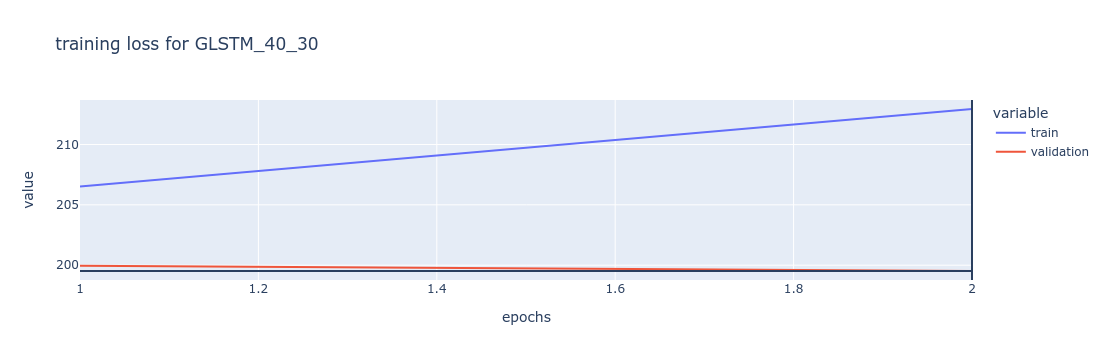

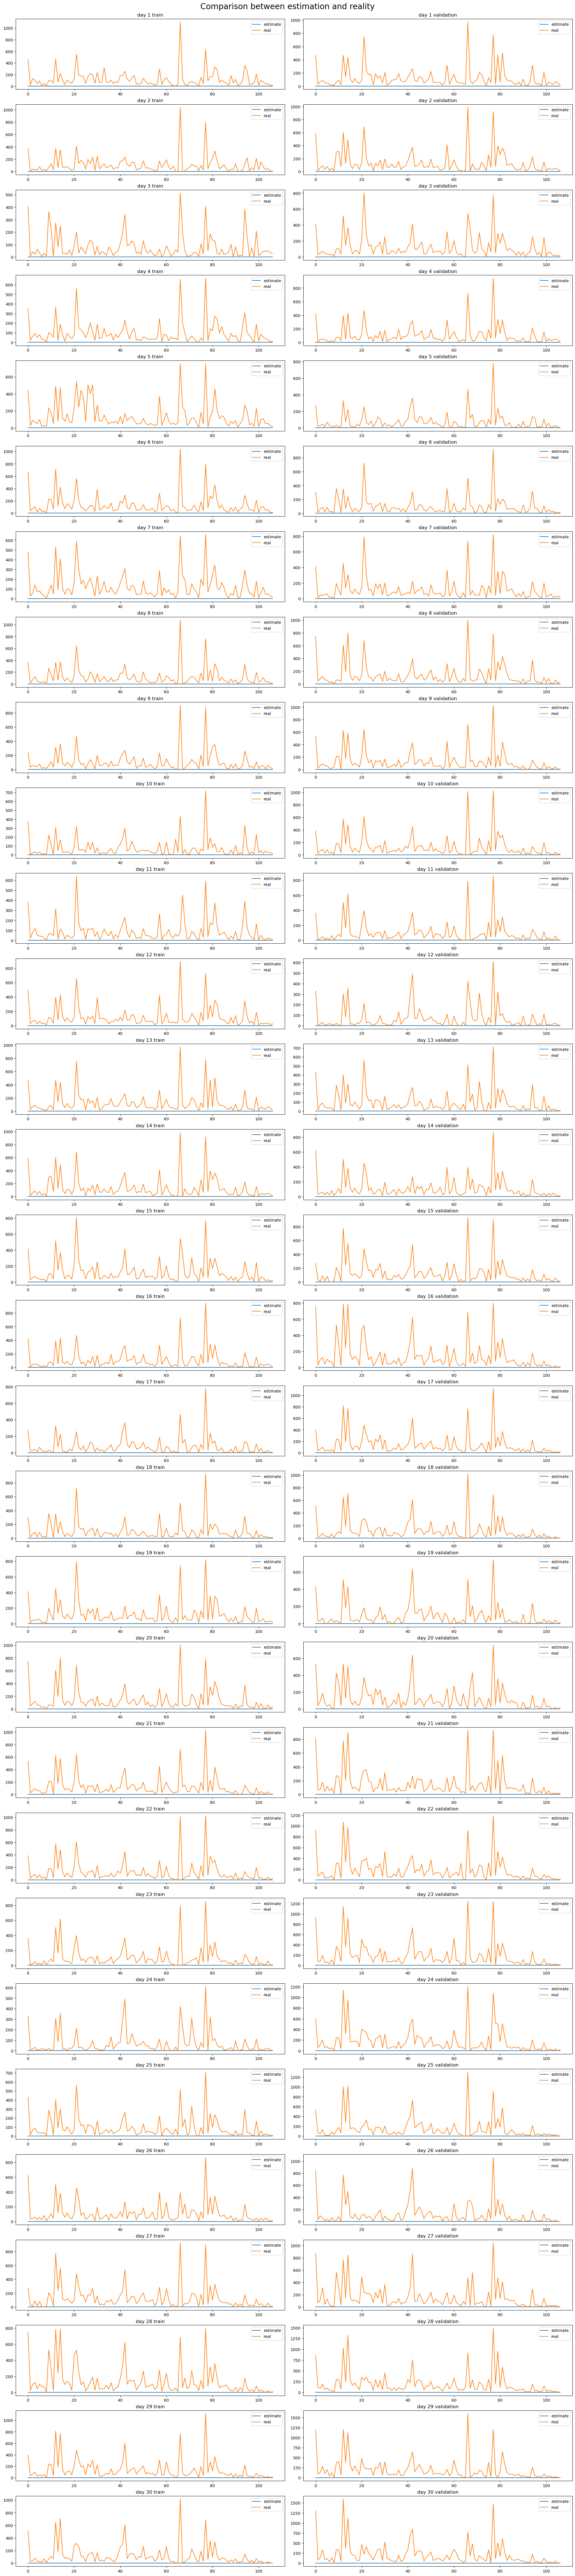

In [11]:
plot(model,
     config,
     loss_training, 
     loss_validation, 
     f"GLSTM_{past_step}_{future_step}", 
     show = True)